In [5]:
import matplotlib
import pandas as pd
import numpy as np 
#import pandas_profiling as pp

import scipy
import copy
import sklearn 

from sklearn           import model_selection
from sklearn.neighbors import LocalOutlierFactor

from scipy import stats

**Let's load the Data**

In [6]:
train = pd.read_hdf('/home/sid2018-1/Bureau/Défi IA anomaly Detection/train.hdf5')
valid = pd.read_hdf('/home/sid2018-1/Bureau/Défi IA anomaly Detection/validation.hdf5')
test  = pd.read_hdf('/home/sid2018-1/Bureau/Défi IA anomaly Detection/test.hdf5')

In [7]:
print('the shape of the datasets are:',train.shape,valid.shape,test.shape)

the shape of the datasets are: (1677, 61440) (594, 61440) (1917, 61440)


**Let's calculate the features**

In [26]:
# Cosine similarity
from scipy import spatial
def simi(v1, vect):
    return 1 - spatial.distance.cosine(v1,vect)

In [27]:
# Correlation with the time
from scipy.stats.stats import pearsonr as corr  
dfeat =pd.DataFrame(data =[corr(train.iloc[k].values,np.arange(len(train.iloc[k].values))) for k in train.index], columns=['corr','pvalue'])
dfeatvalid =pd.DataFrame(data =[corr(valid.iloc[k].values,np.arange(len(valid.iloc[k].values))) for k in valid.index], columns=['corr','pvalue'])
dfeatest =pd.DataFrame(data =[corr(test.iloc[k].values,np.arange(len(test.iloc[k].values))) for k in test.index], columns=['corr','pvalue'])

/home/sid2018-1/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:3399: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


In [28]:
# Max
dfeat['max'] = [np.max(np.abs(train.iloc[k].values)) for k in train.index]
dfeatvalid['max'] = [np.max(np.abs(valid.iloc[k].values)) for k in valid.index]
dfeatest['max'] = [np.max(np.abs(test.iloc[k].values)) for k in test.index]

In [29]:
# Mean
dfeat['mean'] = [(np.mean(train.iloc[k].values)) for k in train.index]
dfeatvalid['mean'] = [(np.mean(valid.iloc[k].values)) for k in valid.index]
dfeatest['mean'] = [(np.mean(test.iloc[k].values)) for k in test.index]

In [30]:
# Energy
dfeat['nrj'] = [(np.sum((train.iloc[k].values)**2)) for k in train.index]
dfeatvalid['nrj'] = [(np.sum((valid.iloc[k].values)**2)) for k in valid.index]
dfeatest['nrj'] = [(np.sum((test.iloc[k].values)**2)) for k in test.index]

In [31]:
# Count the number of pics
def cntpic(o,df):
    l =[]
    val = []
    for k in df.index:
        value =[]
        s =0
        dfx = df.iloc[k].values
        mnost = abs(np.mean(dfx))+ o*np.std(dfx)
        for j in dfx:
            if abs(j) > mnost:
                value.append(abs(j))
                s = s+1
        if value == []:
            val.append(0)
        else:
            val.append(np.max(value) - np.min(value))
        l.append(s)
    return(l,val)

In [32]:
dfeat['cntpic'],dfeat['difvalpic'] =cntpic(6,train)
dfeatvalid['cntpic'],dfeatvalid['difvalpic'] =cntpic(6,valid)
dfeatest['cntpic'],dfeatest['difvalpic'] =cntpic(6,test)

In [34]:
#fenetrage non normalisée sur les données pour une différence de moyennes
def dif_mean(df):
    fn = np.arange(0,61440,1024)
    mat = []
    for k in df.index: 
        l = []
        for j in fn:
            l.append(np.mean(df.iloc[k].values[j:j+1024]))
        mat.append([np.max(l),np.min(l),abs (np.max(l)-np.min(l))])
    return(mat)

In [35]:
matrain = dif_mean(train)
matvalid = dif_mean(valid)
matest = dif_mean(test)
dfmatr = pd.DataFrame(matrain,columns = ['maxmeanf','minmeanf','difmeanf'])
dfmatv = pd.DataFrame(matvalid,columns = ['maxmeanf','minmeanf','difmeanf'])
dfmatt = pd.DataFrame(matest,columns = ['maxmeanf','minmeanf','difmeanf'])
dfeat['maxmeanf'] = dfmatr['maxmeanf']
dfeat['minmeanf'] = dfmatr['minmeanf']
dfeat['difmeanf'] = dfmatr['difmeanf']
dfeatvalid['maxmeanf'] = dfmatv['maxmeanf']
dfeatvalid['minmeanf'] = dfmatv['minmeanf']
dfeatvalid['difmeanf'] = dfmatv['difmeanf']
dfeatest['maxmeanf'] = dfmatt['maxmeanf']
dfeatest['minmeanf'] = dfmatt['minmeanf']
dfeatest['difmeanf'] = dfmatt['difmeanf']

In [38]:
#fenetrage non normalisée sur les données pour une différence de corrélations
def dif_corr(df):
    fn = np.arange(0,61440,1024)
    mat = []
    pval=[]
    for k in df.index: 
        l = []
        val = []
        for j in fn:
            cr = corr(df.iloc[k].values[j:j+1024],np.arange(len(df.iloc[k].values[j:j+1024])))
            l.append(abs(cr[0]) )
            val.append(cr[1])
        mat.append([np.max(l),np.min(l), np.max(l)-np.min(l)])
        pval.append([np.max(val),np.min(val)])
    return(mat,pval)

In [39]:
matcorr,matpval= dif_corr(train)
matcorrv,matpvalv= dif_corr(valid)
matcorrt,matpvalt= dif_corr(test)
dfcorr = pd.DataFrame(matcorr,columns = ['maxcorrf','mincorrf','difcorrf'])
dfcorrv = pd.DataFrame(matcorrv,columns = ['maxcorrf','mincorrf','difcorrf'])
dfcorrt = pd.DataFrame(matcorrt,columns = ['maxcorrf','mincorrf','difcorrf'])
dfpv = pd.DataFrame(matpval,columns = ['maxpvalf','minpvalf'])
dfpvv = pd.DataFrame(matpvalv,columns = ['maxpvalf','minpvalf'])
dfpvt = pd.DataFrame(matpvalt,columns = ['maxpvalf','minpvalf'])
dfeat['maxcorrf'] = dfcorr['maxcorrf']
dfeat['mincorrf'] = dfcorr['mincorrf']
dfeat['difcorrf'] = dfcorr['difcorrf']
dfeat['maxpvalf'] = dfpv['maxpvalf']
dfeat['minpvalf'] = dfpv['minpvalf']

dfeatvalid['maxcorrf'] = dfcorrv['maxcorrf']
dfeatvalid['mincorrf'] = dfcorrv['mincorrf']
dfeatvalid['difcorrf'] = dfcorrv['difcorrf']
dfeatvalid['maxpvalf'] = dfpvv['maxpvalf']
dfeatvalid['minpvalf'] = dfpvv['minpvalf']

dfeatest['maxcorrf'] = dfcorrt['maxcorrf']
dfeatest['mincorrf'] = dfcorrt['mincorrf']
dfeatest['difcorrf'] = dfcorrt['difcorrf']
dfeatest['maxpvalf'] = dfpvt['maxpvalf']
dfeatest['minpvalf'] = dfpvt['minpvalf']

In [41]:
# Calcul similarité de chaque vecteur avec le signal moyen
def calculsim(df,mpc):
    sim = []
    for k in df.index: 
        sim.append(1 - spatial.distance.cosine(mpc, df.iloc[k].values))
    return(sim)

In [42]:
meanpercol = train.mean()
dfeat['sim'] = calculsim(train,meanpercol)
dfeatvalid['sim'] = calculsim(valid,meanpercol)
dfeatest['sim'] = calculsim(test,meanpercol)

/home/sid2018-1/anaconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


In [8]:
from scipy.spatial import distance

# Distance au barycentre des observations normaux
def getbar(df):
    lmoy = []
    lsgm = []
    for k in df.index:
        lmoy.append(np.mean(df.iloc[k].values))
        lsgm.append(np.std(df.iloc[k].values))
    return([np.mean(lmoy),np.mean(lsgm)])

def getdistbar(df,bar):
    dist = []
    for k in df.index:
        dist.append(distance.cityblock([np.mean(df.iloc[k].values),np.std(df.iloc[k].values)],bar))
    return(dist)

In [10]:
def getbar1(df):
    lmoy = []
    lsgm = []
    for k in df.index:
        lmoy.append(np.mean(df.iloc[k].values))
        lsgm.append(np.std(df.iloc[k].values))
    return(lmoy,lsgm)

In [9]:
l1 = getbar(train)

In [11]:
l2,l3 = getbar1(train)

In [22]:
l4,l5 = getbar1(valid)

In [12]:
import matplotlib.pyplot as plt

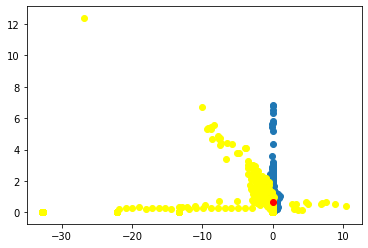

In [25]:
plt.scatter(l2,l3)
plt.plot(np.mean(l2), np.mean(l3),'ro')
plt.scatter(l4,l5, color='yellow')
plt.show()

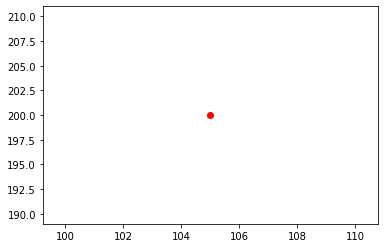

In [20]:
plt.plot(105,200,'ro') 


In [44]:
dfeat['distbar']=getdistbar(train,getbar(train))
dfeatvalid['distbar']=getdistbar(valid,getbar(train))
dfeatest['distbar']=getdistbar(test,getbar(train))

In [46]:
# Normalisons l'energie par l'energie moyen des signaux normaux
em = np.sum( train.mean().values**2) / (len(train.mean().values))
dfeat['rap_em'] = dfeat['nrj'].values/em
dfeatvalid['rap_em'] = dfeatvalid['nrj'].values/em
dfeatest['rap_em'] = dfeatest['nrj'].values/em

In [47]:
# Remplacons les Na dans les cellules avec corrélations
dfeat['corr'],dfeat['maxcorrf'],dfeat['mincorrf'],dfeat['difcorrf'] = dfeat['corr'].fillna(1),dfeat['maxcorrf'].fillna(1),dfeat['mincorrf'].fillna(1),dfeat['difcorrf'].fillna(1)
dfeatvalid['corr'],dfeatvalid['maxcorrf'],dfeatvalid['mincorrf'],dfeatvalid['difcorrf'] = dfeatvalid['corr'].fillna(1),dfeatvalid['maxcorrf'].fillna(1),dfeatvalid['mincorrf'].fillna(1),dfeatvalid['difcorrf'].fillna(1)
dfeatest['corr'],dfeatest['maxcorrf'],dfeatest['mincorrf'],dfeatest['difcorrf'] = dfeatest['corr'].fillna(1),dfeatest['maxcorrf'].fillna(1),dfeatest['mincorrf'].fillna(1),dfeatest['difcorrf'].fillna(1)

In [52]:
# Std
dfeat['std']= [np.std(train.iloc[i].values) for i in train.index ]
dfeatvalid['std']= [np.std(valid.iloc[i].values) for i in valid.index ]
dfeatest['std']= [np.std(test.iloc[i].values) for i in test.index ]

In [53]:
# Normalisation moyenne/std
dfeat['rap_mean_std']= dfeat['mean'].values/dfeat['std'].values
dfeatvalid['rap_mean_std']= dfeatvalid['mean'].values/dfeatvalid['std'].values
dfeatest['rap_mean_std']= dfeatest['mean'].values/dfeatest['std'].values

/home/sid2018-1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until


In [54]:
# difference entre valeurs > mean et < mean
def dif_val_mean(df):
    mat = []
    for k in df.index: 
        l = df.iloc[k].values
        mn = np.mean(l)
        mat.append(sum([ num for num in l if num > mn])- sum([ num for num in l if num < mn]))
    return(mat)

In [55]:
dfeat['dif_val_mean']=dif_val_mean(train)
dfeatvalid['dif_val_mean']=dif_val_mean(valid)
dfeatest['dif_val_mean']=dif_val_mean(test)

In [56]:
# difference entre valeurs > mean et < mean  avec fenetrage
def dif_val_mean_f(df):
    fn = np.arange(0,61440,1024)
    matmax = []
    matmin= []
    for k in df.index: 
        l = []
        for j in fn:
            val = df.iloc[k].values[j:j+1024]
            mn = np.mean(val)
            l.append(sum([ num for num in val if num > mn])- sum([ num for num in val if num < mn]))
        matmax.append(np.max(l))
        matmin.append(np.min(l))
    return(matmax,matmin)

In [57]:
dfeat['max_val_mean'],dfeat['min_val_mean'] =dif_val_mean_f(train)
dfeatvalid['max_val_mean'],dfeatvalid['min_val_mean'] =dif_val_mean_f(valid)
dfeatest['max_val_mean'],dfeatest['min_val_mean'] =dif_val_mean_f(test)

In [58]:
# Fenetrage sur les moyennes normalisées
def dif_meanstd_f(df):
    fn = np.arange(0,61440,1024)
    mat = []    
    for k in df.index: 
        l = []
        for j in fn:
            val = df.iloc[k].values[j:j+1024]
            l.append(np.mean(val)/np.std(val))
        mat.append(np.max(l)-np.min(l))
    return(mat)

In [59]:
dfeat['dif_meanstd_f'] =dif_meanstd_f(train)
dfeatvalid['dif_meanstd_f'] =dif_meanstd_f(valid)
dfeatest['dif_meanstd_f'] =dif_meanstd_f(test)

/home/sid2018-1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in double_scalars
  if __name__ == '__main__':


In [61]:
## Score outlier = cntpic/ difvalpic
dfeat['score_outlier']= dfeat['cntpic'].values/dfeat['difvalpic'].values
dfeatvalid['score_outlier']= dfeatvalid['cntpic'].values/dfeatvalid['difvalpic'].values
dfeatest['score_outlier']= dfeatest['cntpic'].values/dfeatest['difvalpic'].values

/home/sid2018-1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in true_divide
  This is separate from the ipykernel package so we can avoid doing imports until
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in true_divide
  after removing the cwd from sys.path.
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: invalid valu

In [62]:
## dif_val_mean_x_corr dif_val_mean
dfeat['dif_val_mean_x_corr']= dfeat['dif_val_mean'].values * dfeat['corr'].values
dfeatvalid['dif_val_mean_x_corr']= dfeatvalid['dif_val_mean'].values *dfeatvalid['corr'].values
dfeatest['dif_val_mean_x_corr']= dfeatest['dif_val_mean'].values *dfeatest['corr'].values

In [65]:
dfeatvalid.head()

,corr,pvalue,max,mean,nrj,cntpic,difvalpic,maxmeanf,minmeanf,difmeanf,...,distbar,rap_em,std,rap_mean_std,dif_val_mean,max_val_mean,min_val_mean,dif_meanstd_f,score_outlier,dif_val_mean_x_corr
0,0.150945,6.969558e-310,0.382998,0.007689,4.498642e+02,0,0.000000,0.052551,-0.049249,0.101799,...,0.552613,6.466194e+05,0.085223,0.090224,4171.234848,89.374821,44.914854,1.333214,-1.000000,629.627367
1,-0.120029,6.709291e-196,16.348537,-1.922069,4.010436e+05,11,4.128357,-1.395629,-2.667656,1.272027,...,2.979689,5.764463e+08,1.683168,-1.141935,76570.839296,1575.204094,1047.670365,0.371713,2.664498,-9190.690588
2,0.000980,8.080537e-01,0.663285,-0.008438,2.528157e+03,0,0.000000,-0.004839,-0.013254,0.008415,...,0.451287,3.633886e+06,0.202675,-0.041633,10741.364298,214.912961,93.121062,0.060336,-1.000000,10.527795
3,-0.003233,4.229623e-01,0.469974,0.000922,2.314744e+02,4,0.092352,0.012329,-0.009554,0.021882,...,0.583229,3.327133e+05,0.061373,0.015029,2962.768382,84.389671,30.075087,0.255353,43.312617,-9.577913
4,0.271010,0.000000e+00,31.633011,-7.428013,4.761093e+06,0,0.000000,-3.010820,-9.914334,6.903514,...,11.526486,6.843431e+09,4.724021,-1.572392,184098.042070,4239.248612,1278.078820,1.048539,-1.000000,49892.413938


In [64]:
# Fill Na to -1 for the values of score_outlier : 
dfeat['score_outlier']= dfeat['score_outlier'].fillna(-1)
dfeatvalid['score_outlier']= dfeatvalid['score_outlier'].fillna(-1)
dfeatest['score_outlier']= dfeatest['score_outlier'].fillna(-1)

In [66]:
# Let's Keep the absolute value for these features
dfeat['corr']= np.abs(dfeat['corr'].values)
dfeatvalid['corr']= np.abs(dfeatvalid['corr'].values)
dfeatest['corr']= np.abs(dfeatest['corr'].values)

dfeat['rap_mean_std']= np.abs(dfeat['rap_mean_std'].values)
dfeatvalid['rap_mean_std']= np.abs(dfeatvalid['rap_mean_std'].values)
dfeatest['rap_mean_std']= np.abs(dfeatest['rap_mean_std'].values)

dfeat['dif_val_mean_x_corr']= np.abs(dfeat['dif_val_mean_x_corr'].values)
dfeatvalid['dif_val_mean_x_corr']= np.abs(dfeatvalid['dif_val_mean_x_corr'].values)
dfeatest['dif_val_mean_x_corr']= np.abs(dfeatest['dif_val_mean_x_corr'].values)

In [78]:
# Autocorrélation
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size//2:]

In [81]:
# Similarité cosinus avec l'autocorrélation du signal normal moyen 
def calculsim_auto(df,mpc):
    sim = []
    for k in df.index: 
        sim.append(1 - spatial.distance.cosine(mpc, autocorr(df.iloc[k].values)))
    return(sim)

In [82]:
meanpercolauto = autocorr(train.mean())
dfeat['sim_auto'] = calculsim_auto(train,meanpercolauto)
dfeatvalid['sim_auto'] = calculsim_auto(valid,meanpercolauto)
dfeatest['sim_auto'] = calculsim_auto(test,meanpercolauto)

/home/sid2018-1/anaconda3/lib/python3.7/site-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


In [83]:
dfeat['dif_meanstd_f']=dfeat['dif_meanstd_f'].fillna(7516585736263634)
dfeatvalid['dif_meanstd_f']=dfeatvalid['dif_meanstd_f'].fillna(7516585736263634)
dfeatest['dif_meanstd_f']=dfeatest['dif_meanstd_f'].fillna(7516585736263634)

In [84]:
dfeat['dif_val_mean_x_corr']= np.abs(dfeat['dif_val_mean_x_corr'].values)
dfeatvalid['dif_val_mean_x_corr']= np.abs(dfeatvalid['dif_val_mean_x_corr'].values)
dfeatest['dif_val_mean_x_corr']= np.abs(dfeatest['dif_val_mean_x_corr'].values)

**Let's save now the feature Dataframes**

In [90]:
dfeat.to_csv('/home/sid2018-1/Bureau/Défi IA anomaly Detection/final_feat_train',header=True, index= False)
dfeatvalid.to_csv('/home/sid2018-1/Bureau/Défi IA anomaly Detection/final_feat_valid',header=True, index= False)
dfeatest.to_csv('/home/sid2018-1/Bureau/Défi IA anomaly Detection/final_feat_test',header=True, index= False)

# We're Building now our models

**Let's load first the feature Datasets**

In [482]:
dfeat= pd.read_csv('/home/sid2018-1/Bureau/Défi IA anomaly Detection/final_feat_train')
dfeatvalid= pd.read_csv('/home/sid2018-1/Bureau/Défi IA anomaly Detection/final_feat_valid')
dfeatest= pd.read_csv('/home/sid2018-1/Bureau/Défi IA anomaly Detection/final_feat_test')

In [169]:
ref_valid = pd.read_csv('/home/sid2018-1/Bureau/Défi IA anomaly Detection/reference_valid.csv', sep = ';')

In [325]:
ref_valid['anomaly']

0      0
1      1
2      0
3      0
4      1
5      1
6      0
7      0
8      1
9      0
10     0
11     0
12     1
13     0
14     1
15     0
16     1
17     1
18     0
19     0
20     0
21     1
22     0
23     0
24     1
25     1
26     0
27     1
28     1
29     0
      ..
564    0
565    0
566    0
567    1
568    1
569    1
570    0
571    0
572    0
573    0
574    0
575    0
576    1
577    1
578    1
579    1
580    1
581    1
582    1
583    1
584    0
585    1
586    1
587    1
588    0
589    1
590    1
591    0
592    1
593    1
Name: anomaly, Length: 594, dtype: int64

**Let's build a model now**

In [305]:
lsorted = sorted(list(enumerate(dfeatvalid['distbar'].values)),reverse = True, key= lambda a:a[1])
indicesorted = [a for a,b in lsorted[0:int(len(lsorted)/2)]]
predseuil = [1 if i in indicesorted else 0 for i in range(len(lsorted))]

In [375]:
from sklearn.metrics import f1_score
f1_score(predseuil, ref_valid['anomaly'].values,'weigtfv*hed')

0.8504201680672269

In [181]:
ref_valid1 = pd.read_csv('/home/sid2018-1/Bureau/Défi IA anomaly Detection/predseuil_distbar.csv', sep = ';')

In [191]:
dfeatvalid.columns

Index(['corr', 'pvalue', 'max', 'mean', 'nrj', 'cntpic', 'difvalpic',
       'maxmeanf', 'minmeanf', 'difmeanf', 'maxcorrf', 'mincorrf', 'difcorrf',
       'maxpvalf', 'minpvalf', 'sim', 'distbar', 'rap_em', 'std',
       'rap_mean_std', 'dif_val_mean', 'max_val_mean', 'min_val_mean',
       'dif_meanstd_f', 'score_outlier', 'dif_val_mean_x_corr', 'sim_auto'],
      dtype='object')

In [194]:
dfeatvalid['max']

0       0.382998
1      16.348537
2       0.663285
3       0.469974
4      31.633011
5      13.169765
6       0.789356
7       3.473514
8      20.979712
9       2.034294
10      1.342509
11      0.637090
12      8.577669
13      0.204641
14     32.766985
15      0.737414
16     31.480627
17      3.844795
18      1.254234
19      1.451791
20      2.780549
21     13.352138
22      0.857717
23      3.255926
24      3.693304
25      9.501430
26      0.585056
27     21.678953
28     22.161320
29      0.929335
         ...    
564     1.294693
565     1.604352
566     1.180390
567     4.995785
568    20.743764
569     6.266444
570     1.847958
571     0.219854
572     0.246189
573     2.268731
574     1.699285
575     3.360634
576    22.578052
577    32.693421
578     6.270008
579    10.938275
580    21.400773
581    29.272301
582    15.881022
583     4.307640
584     1.869704
585    16.187283
586     1.248397
587    15.231673
588     0.315141
589    19.527720
590    13.352138
591     2.1611

In [483]:
to_keep = ['max','difmeanf','difvalpic','rap_mean_std','sim_auto','dif_val_mean_x_corr','rap_em','distbar']

In [484]:
dftrain = dfeat[to_keep]
dftest = dfeatest[to_keep]
dfvalid = dfeatvalid[to_keep]

In [485]:
dfvalid.head(10)

,max,difmeanf,difvalpic,rap_mean_std,sim_auto,dif_val_mean_x_corr,rap_em,distbar
0,0.382998,0.101799,0.000000,0.090224,0.340854,629.627367,6.466194e+05,0.552613
1,16.348537,1.272027,4.128357,1.141935,0.854999,9190.690588,5.764463e+08,2.979689
2,0.663285,0.008415,0.000000,0.041633,0.013398,10.527795,3.633886e+06,0.451287
3,0.469974,0.021882,0.092352,0.015029,0.009084,9.577913,3.327133e+05,0.583229
4,31.633011,6.903514,0.000000,1.572392,0.866423,49892.413938,6.843431e+09,11.526486
5,13.169765,3.453163,2.038644,0.751328,0.850454,25099.100934,3.751857e+08,2.260440
6,0.789356,0.014441,0.000000,0.047362,0.036641,42.661233,3.166808e+06,0.465329
7,3.473514,0.285728,0.000000,0.053934,0.122091,1136.644710,4.778892e+07,0.148624
8,20.979712,5.320434,5.321119,0.971538,0.872921,13332.625339,8.637281e+08,3.796761
9,2.034294,0.169493,0.000000,0.048880,0.051821,412.992376,1.553606e+07,0.247070


**Kde**

In [486]:
from sklearn import preprocessing
mm_scaler = preprocessing.MinMaxScaler() #or standard Scaler ? 

In [487]:
trnkdesc = mm_scaler.fit_transform(dftrain)
testkdesc = mm_scaler.transform(dftest)
validkdesc = mm_scaler.fit_transform(dfvalid)

In [488]:
X_train = pd.DataFrame(trnkdesc,columns = dftrain.columns)
X_test= pd.DataFrame(testkdesc,columns = dftest.columns)
X_valid = pd.DataFrame(validkdesc,columns = dfvalid.columns)

In [312]:
X_valid.head(10)

,max,difmeanf,difvalpic,rap_mean_std,sim_auto,dif_val_mean_x_corr,rap_em,distbar
0,0.010715,0.003123,0.000000,2.878680e-17,0.374218,0.000462,0.000007,0.013869
1,0.457398,0.039020,0.365510,3.659894e-16,0.947279,0.006750,0.006081,0.076701
2,0.018557,0.000258,0.000000,1.320739e-17,0.009239,0.000008,0.000038,0.011246
3,0.013149,0.000671,0.008177,4.677538e-18,0.004431,0.000007,0.000004,0.014661
4,0.885027,0.211766,0.000000,5.040038e-16,0.960013,0.036643,0.072191,0.297959
5,0.368463,0.105926,0.180494,2.407517e-16,0.942214,0.018434,0.003958,0.058081
6,0.022085,0.000443,0.000000,1.504420e-17,0.035145,0.000031,0.000033,0.011609
7,0.097182,0.008765,0.000000,1.715135e-17,0.130386,0.000835,0.000504,0.003410
8,0.586969,0.163205,0.471113,3.113563e-16,0.967255,0.009792,0.009111,0.097853
9,0.056915,0.005199,0.000000,1.553073e-17,0.052064,0.000303,0.000164,0.005959


In [489]:
vip = ['sim_auto','difmeanf','dif_val_mean_x_corr'] 
#,'dif_val_mean_x_corr','distbar','max',,'distbar'

In [490]:
X_train= X_train[vip]
X_test = X_test[vip]
X_valid = X_valid[vip]

In [491]:
X_valid['sim_auto']=X_valid['sim_auto'].fillna(1)
X_test['sim_auto'] = X_test['sim_auto'].fillna(1)

In [316]:
X_valid.isnull().values.any()

False

In [492]:
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
grid = GridSearchCV(KernelDensity(),
                    {'bandwidth': np.linspace(0.001, 1, 100)},
                    cv=20) # 20-fold cross-validation
grid.fit(X_train)
print (grid.best_params_)

{'bandwidth': 0.021181818181818184}


/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [493]:
ytrain = np.zeros(len(dfeat))

In [494]:
clf = KernelDensity(bandwidth=0.021181818181818184 )
clf.fit(X_train, ytrain)

KernelDensity(algorithm='auto', atol=0, bandwidth=0.021181818181818184,
              breadth_first=True, kernel='gaussian', leaf_size=40,
              metric='euclidean', metric_params=None, rtol=0)

In [495]:
ypred = clf.score_samples(X_valid)

In [496]:
ypredt = clf.score_samples(X_test)

In [497]:
ypredt

array([-8.03391047,  5.02379692,  6.55282779, ...,  5.37113682,
        6.17776609,  5.9997723 ])

In [498]:
lsorted = sorted(list(enumerate(ypred)),reverse = False, key= lambda a:a[1])
indicesorted = [a for a,b in lsorted[0:int(len(lsorted)/2)]]
predseuil = [1 if i in indicesorted else 0 for i in range(len(lsorted))]

In [499]:
predseuil

[1,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 1,
 0,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 0,
 1,
 1,
 1,
 0,
 1,
 0,
 0,


In [500]:
pred_test = [1 if i < lsorted[int(len(lsorted)/2)][1] else 0 for i in ypredt]

In [505]:
sum(pred_test)/len(pred_test)

0.40219092331768386

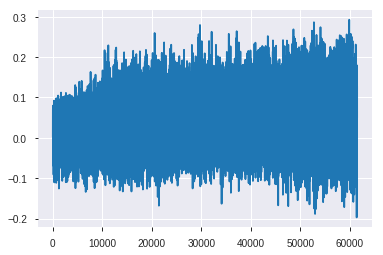

In [531]:
plt.plot(test.iloc[5].values)

In [527]:
for i,k in enumerate(yred):
    if k == 1:
        plt.plot(test.iloc[i].values)
        plt.savefig("/home/sid2018-1/Bureau/Défi IA anomaly Detection/lof22%/"+str(i)+".png")
        plt.clf()

<Figure size 432x288 with 0 Axes>

In [528]:
dfpredseuil = pd.DataFrame(yred,columns=['anomaly'])
dfpredseuil['seqID'] = dfpredseuil.index
dfpredseuil= dfpredseuil[['seqID','anomaly']]
dfpredseuil.head()

,seqID,anomaly
0,0,0
1,1,1
2,2,0
3,3,0
4,4,0


In [507]:
sum(dfpredseuil['anomaly'])/1917

0.40219092331768386

In [529]:
dfpredseuil.to_csv('/home/sid2018-1/Bureau/Défi IA anomaly Detection/final_soum1_lof_yred_22%.csv',header=True,index= False,sep=';')


**Isolation Forest**

In [509]:
iso_keep = ['difmeanf','rap_mean_std','sim_auto','dif_val_mean_x_corr']
#,'rap_em','distbar'

In [510]:
train_iso = dftrain[iso_keep]
valid_iso = dfvalid[iso_keep]
test_iso =  dftest[iso_keep]

In [511]:
from sklearn.ensemble import IsolationForest
from sklearn.metrics import make_scorer, f1_score
from sklearn import model_selection

clf = IsolationForest(random_state=47, behaviour='new')

param_grid = {'n_estimators': list(range(1, 100))}

f1sc = make_scorer(f1_score,average ='micro')

grid_dt_estimator = model_selection.GridSearchCV(clf, 
                                                 param_grid,
                                                 scoring=f1sc, 
                                                 refit=True,
                                                 cv=10, 
                                                 return_train_score=True)
grid_dt_estimator.fit(train_iso, ytrain)

/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/

/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/

/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/

/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/

/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/

/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/

/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/

/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/

/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/

/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/

/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/

/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/

/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/

/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/

/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/

/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/

/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/

/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/

/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/

/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/

/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/

/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/

/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/

/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/

/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/

/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/

/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/

/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/iforest.py:237: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/home/sid2018-1/anaconda3/lib/python3.7/

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=IsolationForest(behaviour='new', bootstrap=False,
                                       contamination='legacy', max_features=1.0,
                                       max_samples='auto', n_estimators=100,
                                       n_jobs=None, random_state=47, verbose=0,
                                       warm_start=False),
             iid='warn', n_jobs=None,
             param_grid={'n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                          13, 14, 15, 16, 17, 18, 19, 20, 21,
                                          22, 23, 24, 25, 26, 27, 28, 29, 30, ...]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=make_scorer(f1_score, average=micro), verbose=0)

In [520]:
ypred= grid_dt_estimator.predict(test_iso)

In [522]:
yred =[0 if i==1 else 1 for i in ypred]

In [526]:
list(yred).count(1)/1917

0.22430881585811163

**Vote des features**

In [390]:
dfvalid['sim_auto']=dfvalid['sim_auto'].fillna(1)
dftest['sim_auto'] = dftest['sim_auto'].fillna(1)

/home/sid2018-1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/home/sid2018-1/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [408]:
#max
lsorted_m = sorted(list(enumerate(dfvalid['max'].values)),reverse = True, key= lambda a:a[1])
predseuil_max = [1 if i > lsorted_m[int(len(lsorted_m)/2)][1] else 0 for i in dftest['max'].values]

#difmeanf
lsorted_dmf = sorted(list(enumerate(dfvalid['difmeanf'].values)),reverse = True, key= lambda a:a[1])
predseuil_dmf = [1 if i > lsorted_dmf[int(len(lsorted_dmf)/2)][1] else 0 for i in dftest['difmeanf'].values]

#distbar
lsorted_rms = sorted(list(enumerate(dfvalid['distbar'].values)),reverse = True, key= lambda a:a[1])
predseuil_rms = [1 if i > lsorted_rms[int(len(lsorted_rms)/2)][1] else 0 for i in dftest['distbar'].values]

#simauto
lsorted_sa = sorted(list(enumerate(dfvalid['sim_auto'].values)),reverse = True, key= lambda a:a[1])
predseuil_sa = [1 if i > lsorted_sa[int(len(lsorted_sa)/2)][1] else 0 for i in dftest['sim_auto'].values]

#dvmc
lsorted_dvmc = sorted(list(enumerate(dfvalid['dif_val_mean_x_corr'].values)),reverse = True, key= lambda a:a[1])
predseuil_dvmc = [1 if i > lsorted_dvmc[int(len(lsorted_dvmc)/2)][1] else 0 for i in dftest['dif_val_mean_x_corr'].values]

In [393]:
dfvalid.head()

,max,difmeanf,difvalpic,rap_mean_std,sim_auto,dif_val_mean_x_corr,rap_em,distbar
0,0.382998,0.101799,0.000000,0.090224,0.340854,629.627367,6.466194e+05,0.552613
1,16.348537,1.272027,4.128357,1.141935,0.854999,9190.690588,5.764463e+08,2.979689
2,0.663285,0.008415,0.000000,0.041633,0.013398,10.527795,3.633886e+06,0.451287
3,0.469974,0.021882,0.092352,0.015029,0.009084,9.577913,3.327133e+05,0.583229
4,31.633011,6.903514,0.000000,1.572392,0.866423,49892.413938,6.843431e+09,11.526486


In [409]:
dfvote =  pd.DataFrame(predseuil_max,columns=['max'])
dfvote['difmeanf'] = predseuil_dmf
dfvote['distbar']=predseuil_rms
dfvote['simauto']= predseuil_sa
dfvote['dvmc']= predseuil_dvmc


In [439]:
dfvote = dfvote[['simauto','dvmc','difmeanf']]
dfvote['anomaly'] = [1 if list(dfvote.iloc[k].values).count(1)>list(dfvote.iloc[k].values).count(0) else 0 for k in dfvote.index]

In [443]:
dfvote

,simauto,dvmc,difmeanf,anomaly
0,0,1,1,1
1,1,0,0,0
2,0,0,0,0
3,0,1,1,1
4,0,0,0,0
5,1,1,0,1
6,0,0,1,0
7,0,0,1,0
8,0,0,0,0
9,0,1,1,1


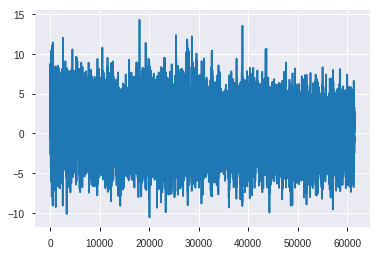

In [451]:
plt.plot(test.iloc[1895].values)

In [452]:
dfvote['seqID'] = dfvote.index
dfvote= dfvote[['seqID','anomaly']]
dfvote.head()

,seqID,anomaly
0,0,1
1,1,0
2,2,0
3,3,1
4,4,0


In [453]:
dfvote.to_csv('/home/sid2018-1/Bureau/Défi IA anomaly Detection/final_soum1_vote.csv',header=True,index= False,sep=';')
